<a href="https://colab.research.google.com/github/FFI-Vietnam/camtrap-tools/blob/main/MegaDetector/confusion_matrix/03_create-confusion-matrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
This script evaluates recall accuracy of MegaDetector from a ground-truth dataset
and a result json file. Then it creates a set of visualization of recall values 
on each group of species.

After runnning this script, new files are created in data cleaning folder 

data cleaning
    |__ 03_confusion-matrix-recall.csv
    
"""

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
import json
import requests
import os
from tqdm.notebook import tqdm

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [26]:
# specifies Colab directories and file names
root = '/content/drive/'

dataset_folder = 'My Drive/FFI/MegaDetector Test/confusion-matrix/dataset'
contain_folder = 'My Drive/FFI/MegaDetector Test/confusion-matrix/data cleaning'
image_folder = 'My Drive/FFI/MegaDetector Test/confusion-matrix/visualization'

ground_truth_file_name = '01_ground-truth-table_Kon-Plong.csv'
MD_result_file_name = 'MegaDetector_result_2021-08-27.json'
taxon_match_table_file_name = '02_taxon-database-with-conservation-status.csv'
confusion_matrix_recall_file_name = '03_confusion-matrix-recall_0.5_independent-event.csv'
threshold_recall_matrix_file_name = '03_threshold-recall-reduction.csv'
threshold_recall_plot_file_name = 'by independent event/03_threshold-recall-reduction.jpg'

In [32]:
# read and save file functions
def read_csv_Google_drive(root, contain_folder, file_name):
  file_path = os.path.join(root, contain_folder, file_name)
  return pd.read_csv(file_path)

def save_csv_Google_drive(df, root, contain_folder, file_name, index=False):
  """
  function to save a csv file to Google Drive
  param examples:
    root = '/content/drive/'
    contain_folder = 'My Drive/FFI/dataset'
    file_name = 'image_metadata(2020-06-26)_full.csv'
  """
  # save file to Colab runtime storage (will be deleted when this notebook is closed)
  df.to_csv('dataframe.csv', index=index)

  # save file back to Google Drive for permanent storage
  folder_path = os.path.join(root, contain_folder)
  file_path = os.path.join(root, contain_folder, file_name)
  try:
    os.makedirs(folder_path)
  except:
    pass

  with open('dataframe.csv', 'r') as f:
    df_file = f.read()

  with open(file_path, 'w') as f:
    f.write(df_file)

  print(f'File is saved to {file_name} in Google Drive at {file_path}')

def save_image_Google_drive(plt, root, contain_folder, file_name):
  """
  function to save an image file to Google Drive
  param examples:
    root = '/content/drive/'
    contain_folder = 'My Drive/FFI/dataset'
    file_name = 'MD_recall_all-species.jpg'
  """

  # save file back to Google Drive for permanent storage
  folder_path = os.path.join(root, contain_folder)
  file_path = os.path.join(root, contain_folder, file_name)
  try:
    os.makedirs(folder_path)
  except:
    pass

  plt.savefig(file_path)
  
  print(f'File is saved to {file_name} in Google Drive at {file_path}')

def read_confusion_matrix_Google_drive(root, contain_folder, file_name):
  """
  to read confusion matrix in Google Drive. transform it into a lying rectangle table
  """
  confusion_matrix_recall = read_csv_Google_drive(root, contain_folder, file_name)
  confusion_matrix_recall.set_index('Unnamed: 0', inplace=True)
  confusion_matrix_recall = confusion_matrix_recall.T

  return confusion_matrix_recall

In [6]:
# read ground-truth table
ground_truth_table = read_csv_Google_drive(root, contain_folder, ground_truth_file_name)
ground_truth_table

,FileName,species_common_name,datetime_created,Flash,batch_group,id
0,197__68974__2019-04-27__10-42-20(1).JPG,Human,2019-04-27 10:42:20,No Flash,0,0
1,197__68974__2019-04-27__10-42-21(2).JPG,Human,2019-04-27 10:42:21,No Flash,0,1
2,197__68974__2019-04-27__10-42-22(3).JPG,Human,2019-04-27 10:42:22,No Flash,0,2
3,197__68974__2019-04-27__10-42-44(4).JPG,Human,2019-04-27 10:42:44,No Flash,1,3
4,197__68974__2019-04-27__10-42-45(5).JPG,Human,2019-04-27 10:42:45,No Flash,1,4
...,...,...,...,...,...,...
110281,196__68890__2019-08-05__17-58-54(2).JPG,NaN,2019-08-05 17:58:54,Fired,85333,110281
110282,196__68890__2019-08-05__17-59-22(1).JPG,NaN,2019-08-05 17:59:22,Fired,85334,110282
110283,196__68890__2019-08-06__06-31-24(1).JPG,Rufous-throated Partridge,2019-08-06 06:31:24,Fired,85335,110283
110284,196__68890__2019-08-06__06-31-54(2).JPG,NaN,2019-08-06 06:31:54,Fired,85336,110284


In [7]:
# read MegaDetector result
result_path = os.path.join(root, dataset_folder, MD_result_file_name)
with open(result_path) as f:
  mega_result = json.load(f)

# print sample result
mega_result['images'][5]

{'detections': [{'bbox': [0.5825, 0.9118, 0.4078, 0.08803],
   'category': '1',
   'conf': 0.849},
  {'bbox': [0.003062, 0.8421, 0.1527, 0.1578],
   'category': '1',
   'conf': 0.214}],
 'file': '/content/drive/My Drive/Camera Trap Data/Kon Plong/2019-2020 Survey/Processed images/Final/100/67096/100__67096__2019-04-27__12-50-26(3).JPG',
 'max_detection_conf': 0.849}

In [8]:
# read taxon_match_table
taxon_match_table = read_csv_Google_drive(root, contain_folder, taxon_match_table_file_name)
taxon_match_table.sample(5)

,id,class,order,family,genus,species,authority,commonNameEnglish,taxonomyType,uniqueIdentifier,FFI_species_name,conservation_status
46,2014432,Aves,Passeriformes,Pellorneidae,Trichastoma,tickelli,"Blyth, 1859",Buff-breasted Babbler,biological,bad6ab4c-cedb-4cf9-8a78-d6e6d20c97d9,Buff-breasted Babbler,Least Concern
4,2019996,Mammalia,Carnivora,Mustelidae,Melogale,NaN,NaN,Melogale Species,biological,a6bdb282-2d0c-4f63-866b-e60ffa410d19,Ferret-badger,Not Applicable
112,2005483,Mammalia,Cetartiodactyla,Tragulidae,Tragulus,kanchil,"Raffles, 1821",Lesser Oriental Chevrotain,biological,205a307a-abf2-4a12-9018-5c044b20e97b,Lesser Mouse-deer,Least Concern
80,2021570,Reptilia,Squamata,Varanidae,Varanus,salvator,NaN,Common Water Monitor,biological,bf821325-fbf8-4b48-a437-4c238ad07f90,Asian Water Monitor,Least Concern
42,2015063,Aves,Passeriformes,Turdidae,Turdus,mandarinus,"Bonaparte, 1850",Chinese Blackbird,biological,92b7d46b-43a4-4938-a9f8-65a494f5bdc3,Chinese Blackbird,Least Concern


In [ ]:
# sanity check file consistency between MD results and ground-truth data
in_ground_truth_not_MD = []
in_MD_not_ground_truth = []

ground_truth_table = read_csv_Google_drive(root, contain_folder, ground_truth_file_name)

list_of_MD_filename = []
for i in range(len(mega_result['images'])):
  list_of_MD_filename.append(mega_result['images'][i]['file'].split('/')[-1])

list_of_ground_truth_filename = ground_truth_table['FileName'].to_list()

count_1 = 0
for i in tqdm(range(len(list_of_ground_truth_filename))):
  filename = list_of_ground_truth_filename[i]
  if filename in list_of_MD_filename:
    continue
  count_1 += 1
  in_ground_truth_not_MD.append(filename)

count_2 = 0
for i in tqdm(range(len(mega_result['images']))):
  filename = list_of_MD_filename[i]
  if filename in list_of_ground_truth_filename:
    continue
  count_2 += 1
  in_MD_not_ground_truth.append(filename)

with open('in_ground_truth_not_MD.txt', 'w') as f:
  for i in in_ground_truth_not_MD:
    f.write(i + '\n')
print(f'There are {count_1} files in ground-truth table not found in MegaDetector result. Visit in_ground_truth_not_MD.txt (just created) for details.')

with open('in_MD_not_ground_truth.txt', 'w') as f:
  for i in in_MD_not_ground_truth:
    f.write(i + '\n')
print(f'There are {count_2} files in MegaDetector result not found in ground-truth table. Visit in_MD_not_ground_truth.txt (just created) for details.')


# update ground truth table to contain only files in both
print(f'Ground-truth table original size {len(ground_truth_table)}')
ground_truth_table = ground_truth_table[~ ground_truth_table['FileName'].isin(in_ground_truth_not_MD)]
print(f'Ground-truth table updated size  {len(ground_truth_table)}')

  0%|          | 0/110286 [00:00<?, ?it/s]

  0%|          | 0/110166 [00:00<?, ?it/s]

There are 0 files in ground-truth table not found in MegaDetector result. Visit in_ground_truth_not_MD.txt (just created) for details.
There are 0 files in MegaDetector result not found in ground-truth table. Visit in_MD_not_ground_truth.txt (just created) for details.
Ground-truth table original size 110286
Ground-truth table updated size  110286


In [9]:
def list_labels(mega_result, ground_truth_table, threshold, camera_trigger=True):
  """
  list actual labels and prediction labels
  @params camera_trigger: accounts for images in batch. For example if 3 images in a 
                    batch has 3 animals, but MD could detect only one, that 
                    would be enough to be a correct detection.
  @return: a list of actual labels and a list of predection labels
  """

  def has_any_object_camera_trigger(detection_batch, threshold, category_id):
    for detection in detection_batch:
      for i in range(len(detection)):
        if detection[i]['conf'] > threshold and detection[i]['category'] == category_id:
          return True
    return False

  print(len(mega_result['images']), "images")
  print('Generating actual and prediction lists...')

  # get list of files
  list_of_MD_filename = []
  for i in range(len(mega_result['images'])):
    list_of_MD_filename.append(mega_result['images'][i]['file'].split('/')[-1])

  category = {
      '1': 'Animal',
      '2': 'Human',
      '3': 'Vehicle'
  }

  y_actu = []
  y_pred = []

  if camera_trigger:
    search_range = ground_truth_table['batch_group'].unique()
    column_name = 'batch_group'
  else:
    search_range = ground_truth_table['id'].unique()
    column_name = 'id'

  """
  treat each batch as an image
  # in case batch is blank
  if all rows are blank:
    if all predictions are blank:
      actu.append('Blank')
      pred.append('Blank')
    if there is at least one animal in predictions:
      actu.append('Blank')
      pred.append('Animal')

  # in case batch is not blank
  if there are n distinct animals, e.g. Human and Domestic Dog:
    for each distinct animal
      if any of that animal is correctly detected:
        actu.append(distinct_animal)
        pred.append(animal)
      else:
        actu.append(distinct_animal)
        pred.append('Blank')
  """
  for i in tqdm(range(len(search_range))):
    sub_table = ground_truth_table[ground_truth_table[column_name] == search_range[i]]

    filenames = sub_table['FileName'].to_list()

    # store list of detections for the batch
    detection_batch = []

    for f in filenames:
      try:
        detection = mega_result['images'][list_of_MD_filename.index(f)]['detections']
        detection_batch.append(detection)
      except Exception as e:
        # print(str(e))
        print(mega_result['images'][list_of_MD_filename.index(f)])

    # if all images are blank
    if sub_table['species_common_name'].isnull().sum() == len(sub_table):
      # if any Human is detected
      if has_any_object_camera_trigger(detection_batch, threshold, '2'):
        y_actu.append('Blank')
        y_pred.append('Human')
      # if any Animal is detected
      elif has_any_object_camera_trigger(detection_batch, threshold, '1'):
        y_actu.append('Blank')
        y_pred.append('Animal')
      else:
        y_actu.append('Blank')
        y_pred.append('Blank')

    # if there is at least one detection event
    else:
      # list n distinct animal detections
      distinct_animals = sub_table[sub_table['species_common_name'].notnull()]['species_common_name'].unique()

      for animal in distinct_animals:
        
        if animal == 'Human':
          if has_any_object_camera_trigger(detection_batch, threshold, '2'):
            y_actu.append('Human')
            y_pred.append('Human')
          elif has_any_object_camera_trigger(detection_batch, threshold, '1'):
            y_actu.append('Human')
            y_pred.append('Animal')
          else:
            y_actu.append('Human')
            y_pred.append('Blank')
        else:
          if has_any_object_camera_trigger(detection_batch, threshold, '2'):
            y_actu.append(animal)
            y_pred.append('Human')
          elif has_any_object_camera_trigger(detection_batch, threshold, '1'):
            y_actu.append(animal)
            y_pred.append(animal)
          else:
            y_actu.append(animal)
            y_pred.append('Blank')

  return y_actu, y_pred

In [ ]:
# sanity check y_actu and y_pred lists

y_actu = pd.Series(y_actu_test)
y_pred = pd.Series(y_pred_test)

# Test 01: number of images
camera_trigger = True
if camera_trigger:
  count = 0
  for i in tqdm(ground_truth_table['batch_group'].unique()):
    sub_table = ground_truth_table[ground_truth_table['batch_group'] == i]
    count += sub_table[sub_table['species_common_name'].notnull()]['species_common_name'].nunique()
else:
  count = len(ground_truth_table)
if (y_actu!='Blank').sum() == count:
  print('Pass test 01')
else:
  print('Failed test 01: Has', (y_actu!='Blank').sum(), 'but expects', count)

  0%|          | 0/79939 [00:00<?, ?it/s]

Failed test 01: Has 25759 but expects 22017


In [ ]:
#@title temporary hidden
def list_labels(mega_result, ground_truth_table, THRESHOLD):
  """
  list actual labels and prediction labels
  """

  def has_object(detections, threshold, category_id):
    for i in range(len(detections)):
      if detections[i]['conf'] > threshold and detections[i]['category'] == category_id:
        return True
    return False

  print(len(mega_result['images']), "images")
  print('Generating actual and prediction lists...')

  # get list of files
  files = []
  for i in range(len(mega_result['images'])):
    files.append(mega_result['images'][i]['file'].split('/')[-1])

  category = {
      '1': 'Animal',
      '2': 'Human',
      '3': 'Vehicle'
  }

  y_actu = []
  y_pred = []

  count = 0

  for i in tqdm(range(len(ground_truth_table))):
    try:
      # actual label
      actu = ground_truth_table['species_common_name'].iat[i]

      filename = ground_truth_table['FileName'].iat[i]

      # prediction label

      # if the image has any human
      if has_object(mega_result['images'][files.index(filename)]['detections'], THRESHOLD, '2'):
        y_pred.append('Human')
        if str(actu) == 'nan':
          y_actu.append('Blank')
        else:
          y_actu.append(actu)
      # if the image has any animal
      elif has_object(mega_result['images'][files.index(filename)]['detections'], THRESHOLD, '1'):
        if str(actu) == 'nan':
          y_pred.append('Animal')
          y_actu.append('Blank')
        else:
          y_pred.append(actu)
          y_actu.append(actu)

      # if not have any human or animal
      elif (not has_object(mega_result['images'][files.index(filename)]['detections'], THRESHOLD, '1')) and (not has_object(mega_result['images'][files.index(filename)]['detections'], THRESHOLD, '2')):
        y_pred.append('Blank')
        if str(actu) == 'nan':
          y_actu.append('Blank')
        else:
          y_actu.append(actu)    
    except Exception as e:
      count += 1
      # print(str(e))
      pass
  print(count)
  y_pr = np.array(y_pred)
  print('Reduction rate', len(y_pr[y_pr == 'Blank']) / len(y_pr))
  return y_actu, y_pred


y_actu_ground, y_pred_ground = list_labels(mega_result, ground_truth_table, 0.5)

110166 images
Generating actual and prediction lists...


  0%|          | 0/110318 [00:00<?, ?it/s]

9263
Reduction rate 0.7793676710702093


In [ ]:
print('ground', len(y_actu_ground))
print('test  ', len(y_actu_test))

print('ground', len(y_pred_ground))
print('test  ', len(y_pred_test))

print(y_actu_test == y_actu_ground)

for i in range(len(y_pred_test)):
  if y_pred_test[i] != y_pred_ground[i]:

    print(y_pred_test[i], y_pred_ground[i])

# pd.DataFrame({'y_actu_ground':y_actu_ground, 'y_actu_test': y_actu_test})
# pd.DataFrame({'y_pred_ground':y_pred_ground, 'y_pred_test': y_pred_test}).to_csv('prediction.csv')

ground 101055
test   101055
ground 101055
test   101055


In [10]:
def create_confusion_matrix_recall(threshold, camera_trigger):

  y_actu, y_pred = list_labels(mega_result, ground_truth_table, threshold, camera_trigger=camera_trigger)

  print('Generating confusion matrix...')

  y_actu = pd.Series(y_actu, name='Actual')
  y_pred = pd.Series(y_pred, name='Prediction')
  df_confusion = pd.crosstab(y_pred, y_actu, rownames=['Prediction'], colnames=['Actual'], margins=True)
  
  # collapse rows
  confusion_matrix_recall = pd.DataFrame(index = ['Animal', 'Human', 'Blank', 'Total', 'Recall'])
  for col in df_confusion.columns:
    all = df_confusion[col]['All']
    animal = all - df_confusion[col]['Blank'] - df_confusion[col]['Human']
    human = df_confusion[col]['Human']
    blank = df_confusion[col]['Blank']
    total = animal + human + blank
    confusion_matrix_recall[col] = [animal, human, blank, total, 0] # leave a blank cell for recall value
  
  # lump the Murid rodent family
  confusion_matrix_recall['Murid'] = confusion_matrix_recall['Murid'] + confusion_matrix_recall['Leopoldamys'] + confusion_matrix_recall['Maxomys']

  # drop columns 
  confusion_matrix_recall.drop(columns=['Moth', 'Bat', 'Flying Insect', 'Leopoldamys', 'Maxomys', 'Butterfly'], inplace=True)
  
  # cast from int to float to save recall value
  confusion_matrix_recall = confusion_matrix_recall.astype('float')

  # add recall row
  for col in confusion_matrix_recall.columns:
    if col == 'Blank':
      confusion_matrix_recall[col][4] = round(int(confusion_matrix_recall[col][2]) / int(confusion_matrix_recall[col][3]), 2)
    elif col == 'Human':
      confusion_matrix_recall[col][4] = round(int(confusion_matrix_recall[col][1]) / int(confusion_matrix_recall[col][3]), 2)
    else:
      confusion_matrix_recall[col][4] = round(int(confusion_matrix_recall[col][0]) / int(confusion_matrix_recall[col][3]), 2)

  return confusion_matrix_recall

In [11]:
# confusion_matrix_recall_01 = create_confusion_matrix_recall(0.01, True)
# save_csv_Google_drive(confusion_matrix_recall_01.T, root, contain_folder, "03_confusion-matrix-recall_0.01_independent-event.csv", index=True)

# confusion_matrix_recall_10 = create_confusion_matrix_recall(0.1, True)
# save_csv_Google_drive(confusion_matrix_recall_10.T, root, contain_folder, "03_confusion-matrix-recall_0.1_independent-event.csv", index=True)

# confusion_matrix_recall_20 = create_confusion_matrix_recall(0.2, True)
# save_csv_Google_drive(confusion_matrix_recall_20.T, root, contain_folder, "03_confusion-matrix-recall_0.2_independent-event.csv", index=True)

# confusion_matrix_recall_30 = create_confusion_matrix_recall(0.3, True)
# save_csv_Google_drive(confusion_matrix_recall_30.T, root, contain_folder, "03_confusion-matrix-recall_0.3_independent-event.csv", index=True)

# confusion_matrix_recall_40 = create_confusion_matrix_recall(0.4, True)
# save_csv_Google_drive(confusion_matrix_recall_40.T, root, contain_folder, "03_confusion-matrix-recall_0.4_independent-event.csv", index=True)

# confusion_matrix_recall_50 = create_confusion_matrix_recall(0.5, True)
# save_csv_Google_drive(confusion_matrix_recall_50.T, root, contain_folder, "03_confusion-matrix-recall_0.5_independent-event.csv", index=True)

# confusion_matrix_recall_60 = create_confusion_matrix_recall(0.6, True)
# save_csv_Google_drive(confusion_matrix_recall_60.T, root, contain_folder, "03_confusion-matrix-recall_0.6_independent-event.csv", index=True)

# confusion_matrix_recall_70 = create_confusion_matrix_recall(0.7, True)
# save_csv_Google_drive(confusion_matrix_recall_70.T, root, contain_folder, "03_confusion-matrix-recall_0.7_independent-event.csv", index=True)

# confusion_matrix_recall_80 = create_confusion_matrix_recall(0.8, True)
# save_csv_Google_drive(confusion_matrix_recall_80.T, root, contain_folder, "03_confusion-matrix-recall_0.8_independent-event.csv", index=True)

confusion_matrix_recall_90 = create_confusion_matrix_recall(0.9, True)
save_csv_Google_drive(confusion_matrix_recall_90.T, root, contain_folder, "03_confusion-matrix-recall_0.9_independent-event.csv", index=True)
# ---
confusion_matrix_recall_no_trigger_01 = create_confusion_matrix_recall(0.01, False)
save_csv_Google_drive(confusion_matrix_recall_no_trigger_01.T, root, contain_folder, "03_confusion-matrix-recall_0.01_without-independent-event.csv", index=True)

confusion_matrix_recall_no_trigger_10 = create_confusion_matrix_recall(0.1, False)
save_csv_Google_drive(confusion_matrix_recall_no_trigger_10.T, root, contain_folder, "03_confusion-matrix-recall_0.1_without-independent-event.csv", index=True)

confusion_matrix_recall_no_trigger_20 = create_confusion_matrix_recall(0.2, False)
save_csv_Google_drive(confusion_matrix_recall_no_trigger_20.T, root, contain_folder, "03_confusion-matrix-recall_0.2_without-independent-event.csv", index=True)

confusion_matrix_recall_no_trigger_30 = create_confusion_matrix_recall(0.3, False)
save_csv_Google_drive(confusion_matrix_recall_no_trigger_30.T, root, contain_folder, "03_confusion-matrix-recall_0.3_without-independent-event.csv", index=True)

confusion_matrix_recall_no_trigger_40 = create_confusion_matrix_recall(0.4, False)
save_csv_Google_drive(confusion_matrix_recall_no_trigger_40.T, root, contain_folder, "03_confusion-matrix-recall_0.4_without-independent-event.csv", index=True)

confusion_matrix_recall_no_trigger_50 = create_confusion_matrix_recall(0.5, False)
save_csv_Google_drive(confusion_matrix_recall_no_trigger_50.T, root, contain_folder, "03_confusion-matrix-recall_0.5_without-independent-event.csv", index=True)

confusion_matrix_recall_no_trigger_60 = create_confusion_matrix_recall(0.6, False)
save_csv_Google_drive(confusion_matrix_recall_no_trigger_60.T, root, contain_folder, "03_confusion-matrix-recall_0.6_without-independent-event.csv", index=True)

confusion_matrix_recall_no_trigger_70 = create_confusion_matrix_recall(0.7, False)
save_csv_Google_drive(confusion_matrix_recall_no_trigger_70.T, root, contain_folder, "03_confusion-matrix-recall_0.7_without-independent-event.csv", index=True)

confusion_matrix_recall_no_trigger_80 = create_confusion_matrix_recall(0.8, False)
save_csv_Google_drive(confusion_matrix_recall_no_trigger_80.T, root, contain_folder, "03_confusion-matrix-recall_0.8_without-independent-event.csv", index=True)

confusion_matrix_recall_no_trigger_90 = create_confusion_matrix_recall(0.9, False)
save_csv_Google_drive(confusion_matrix_recall_no_trigger_90.T, root, contain_folder, "03_confusion-matrix-recall_0.9_without-independent-event.csv", index=True)


110166 images
Generating actual and prediction lists...


  0%|          | 0/85338 [00:00<?, ?it/s]

{'file': '/content/drive/My Drive/Camera Trap Data/Kon Plong/2019-2020 Survey/Processed images/Final/332/68986/kpc332__ct68986__2019-11-04__01-21-58(2)__Blank.JPG', 'failure': 'Failure image access'}
{'file': '/content/drive/My Drive/Camera Trap Data/Kon Plong/2019-2020 Survey/Processed images/Final/332/68986/kpc332__ct68986__2019-11-04__01-22-20(1)__Blank.JPG', 'failure': 'Failure image access'}
{'file': '/content/drive/My Drive/Camera Trap Data/Kon Plong/2019-2020 Survey/Processed images/Final/332/68986/kpc332__ct68986__2019-11-04__04-44-39(2)__Blank.JPG', 'failure': 'Failure image access'}
{'file': '/content/drive/My Drive/Camera Trap Data/Kon Plong/2019-2020 Survey/Processed images/Final/332/68986/kpc332__ct68986__2019-11-04__04-44-59(3)__Blank.JPG', 'failure': 'Failure image access'}
{'file': '/content/drive/My Drive/Camera Trap Data/Kon Plong/2019-2020 Survey/Processed images/Final/332/68986/kpc332__ct68986__2019-11-04__04-45-21(1)__Blank.JPG', 'failure': 'Failure image access'}


  0%|          | 0/110286 [00:00<?, ?it/s]

{'file': '/content/drive/My Drive/Camera Trap Data/Kon Plong/2019-2020 Survey/Processed images/Final/332/68986/kpc332__ct68986__2019-11-04__01-21-58(2)__Blank.JPG', 'failure': 'Failure image access'}
{'file': '/content/drive/My Drive/Camera Trap Data/Kon Plong/2019-2020 Survey/Processed images/Final/332/68986/kpc332__ct68986__2019-11-04__01-22-20(1)__Blank.JPG', 'failure': 'Failure image access'}
{'file': '/content/drive/My Drive/Camera Trap Data/Kon Plong/2019-2020 Survey/Processed images/Final/332/68986/kpc332__ct68986__2019-11-04__04-44-39(2)__Blank.JPG', 'failure': 'Failure image access'}
{'file': '/content/drive/My Drive/Camera Trap Data/Kon Plong/2019-2020 Survey/Processed images/Final/332/68986/kpc332__ct68986__2019-11-04__04-44-59(3)__Blank.JPG', 'failure': 'Failure image access'}
{'file': '/content/drive/My Drive/Camera Trap Data/Kon Plong/2019-2020 Survey/Processed images/Final/332/68986/kpc332__ct68986__2019-11-04__04-45-21(1)__Blank.JPG', 'failure': 'Failure image access'}


  0%|          | 0/110286 [00:00<?, ?it/s]

{'file': '/content/drive/My Drive/Camera Trap Data/Kon Plong/2019-2020 Survey/Processed images/Final/332/68986/kpc332__ct68986__2019-11-04__01-21-58(2)__Blank.JPG', 'failure': 'Failure image access'}
{'file': '/content/drive/My Drive/Camera Trap Data/Kon Plong/2019-2020 Survey/Processed images/Final/332/68986/kpc332__ct68986__2019-11-04__01-22-20(1)__Blank.JPG', 'failure': 'Failure image access'}
{'file': '/content/drive/My Drive/Camera Trap Data/Kon Plong/2019-2020 Survey/Processed images/Final/332/68986/kpc332__ct68986__2019-11-04__04-44-39(2)__Blank.JPG', 'failure': 'Failure image access'}
{'file': '/content/drive/My Drive/Camera Trap Data/Kon Plong/2019-2020 Survey/Processed images/Final/332/68986/kpc332__ct68986__2019-11-04__04-44-59(3)__Blank.JPG', 'failure': 'Failure image access'}
{'file': '/content/drive/My Drive/Camera Trap Data/Kon Plong/2019-2020 Survey/Processed images/Final/332/68986/kpc332__ct68986__2019-11-04__04-45-21(1)__Blank.JPG', 'failure': 'Failure image access'}


  0%|          | 0/110286 [00:00<?, ?it/s]

{'file': '/content/drive/My Drive/Camera Trap Data/Kon Plong/2019-2020 Survey/Processed images/Final/332/68986/kpc332__ct68986__2019-11-04__01-21-58(2)__Blank.JPG', 'failure': 'Failure image access'}
{'file': '/content/drive/My Drive/Camera Trap Data/Kon Plong/2019-2020 Survey/Processed images/Final/332/68986/kpc332__ct68986__2019-11-04__01-22-20(1)__Blank.JPG', 'failure': 'Failure image access'}
{'file': '/content/drive/My Drive/Camera Trap Data/Kon Plong/2019-2020 Survey/Processed images/Final/332/68986/kpc332__ct68986__2019-11-04__04-44-39(2)__Blank.JPG', 'failure': 'Failure image access'}
{'file': '/content/drive/My Drive/Camera Trap Data/Kon Plong/2019-2020 Survey/Processed images/Final/332/68986/kpc332__ct68986__2019-11-04__04-44-59(3)__Blank.JPG', 'failure': 'Failure image access'}
{'file': '/content/drive/My Drive/Camera Trap Data/Kon Plong/2019-2020 Survey/Processed images/Final/332/68986/kpc332__ct68986__2019-11-04__04-45-21(1)__Blank.JPG', 'failure': 'Failure image access'}


  0%|          | 0/110286 [00:00<?, ?it/s]

{'file': '/content/drive/My Drive/Camera Trap Data/Kon Plong/2019-2020 Survey/Processed images/Final/332/68986/kpc332__ct68986__2019-11-04__01-21-58(2)__Blank.JPG', 'failure': 'Failure image access'}
{'file': '/content/drive/My Drive/Camera Trap Data/Kon Plong/2019-2020 Survey/Processed images/Final/332/68986/kpc332__ct68986__2019-11-04__01-22-20(1)__Blank.JPG', 'failure': 'Failure image access'}
{'file': '/content/drive/My Drive/Camera Trap Data/Kon Plong/2019-2020 Survey/Processed images/Final/332/68986/kpc332__ct68986__2019-11-04__04-44-39(2)__Blank.JPG', 'failure': 'Failure image access'}
{'file': '/content/drive/My Drive/Camera Trap Data/Kon Plong/2019-2020 Survey/Processed images/Final/332/68986/kpc332__ct68986__2019-11-04__04-44-59(3)__Blank.JPG', 'failure': 'Failure image access'}
{'file': '/content/drive/My Drive/Camera Trap Data/Kon Plong/2019-2020 Survey/Processed images/Final/332/68986/kpc332__ct68986__2019-11-04__04-45-21(1)__Blank.JPG', 'failure': 'Failure image access'}


  0%|          | 0/110286 [00:00<?, ?it/s]

{'file': '/content/drive/My Drive/Camera Trap Data/Kon Plong/2019-2020 Survey/Processed images/Final/332/68986/kpc332__ct68986__2019-11-04__01-21-58(2)__Blank.JPG', 'failure': 'Failure image access'}
{'file': '/content/drive/My Drive/Camera Trap Data/Kon Plong/2019-2020 Survey/Processed images/Final/332/68986/kpc332__ct68986__2019-11-04__01-22-20(1)__Blank.JPG', 'failure': 'Failure image access'}
{'file': '/content/drive/My Drive/Camera Trap Data/Kon Plong/2019-2020 Survey/Processed images/Final/332/68986/kpc332__ct68986__2019-11-04__04-44-39(2)__Blank.JPG', 'failure': 'Failure image access'}
{'file': '/content/drive/My Drive/Camera Trap Data/Kon Plong/2019-2020 Survey/Processed images/Final/332/68986/kpc332__ct68986__2019-11-04__04-44-59(3)__Blank.JPG', 'failure': 'Failure image access'}
{'file': '/content/drive/My Drive/Camera Trap Data/Kon Plong/2019-2020 Survey/Processed images/Final/332/68986/kpc332__ct68986__2019-11-04__04-45-21(1)__Blank.JPG', 'failure': 'Failure image access'}


  0%|          | 0/110286 [00:00<?, ?it/s]

{'file': '/content/drive/My Drive/Camera Trap Data/Kon Plong/2019-2020 Survey/Processed images/Final/332/68986/kpc332__ct68986__2019-11-04__01-21-58(2)__Blank.JPG', 'failure': 'Failure image access'}
{'file': '/content/drive/My Drive/Camera Trap Data/Kon Plong/2019-2020 Survey/Processed images/Final/332/68986/kpc332__ct68986__2019-11-04__01-22-20(1)__Blank.JPG', 'failure': 'Failure image access'}
{'file': '/content/drive/My Drive/Camera Trap Data/Kon Plong/2019-2020 Survey/Processed images/Final/332/68986/kpc332__ct68986__2019-11-04__04-44-39(2)__Blank.JPG', 'failure': 'Failure image access'}
{'file': '/content/drive/My Drive/Camera Trap Data/Kon Plong/2019-2020 Survey/Processed images/Final/332/68986/kpc332__ct68986__2019-11-04__04-44-59(3)__Blank.JPG', 'failure': 'Failure image access'}
{'file': '/content/drive/My Drive/Camera Trap Data/Kon Plong/2019-2020 Survey/Processed images/Final/332/68986/kpc332__ct68986__2019-11-04__04-45-21(1)__Blank.JPG', 'failure': 'Failure image access'}


  0%|          | 0/110286 [00:00<?, ?it/s]

{'file': '/content/drive/My Drive/Camera Trap Data/Kon Plong/2019-2020 Survey/Processed images/Final/332/68986/kpc332__ct68986__2019-11-04__01-21-58(2)__Blank.JPG', 'failure': 'Failure image access'}
{'file': '/content/drive/My Drive/Camera Trap Data/Kon Plong/2019-2020 Survey/Processed images/Final/332/68986/kpc332__ct68986__2019-11-04__01-22-20(1)__Blank.JPG', 'failure': 'Failure image access'}
{'file': '/content/drive/My Drive/Camera Trap Data/Kon Plong/2019-2020 Survey/Processed images/Final/332/68986/kpc332__ct68986__2019-11-04__04-44-39(2)__Blank.JPG', 'failure': 'Failure image access'}
{'file': '/content/drive/My Drive/Camera Trap Data/Kon Plong/2019-2020 Survey/Processed images/Final/332/68986/kpc332__ct68986__2019-11-04__04-44-59(3)__Blank.JPG', 'failure': 'Failure image access'}
{'file': '/content/drive/My Drive/Camera Trap Data/Kon Plong/2019-2020 Survey/Processed images/Final/332/68986/kpc332__ct68986__2019-11-04__04-45-21(1)__Blank.JPG', 'failure': 'Failure image access'}


  0%|          | 0/110286 [00:00<?, ?it/s]

{'file': '/content/drive/My Drive/Camera Trap Data/Kon Plong/2019-2020 Survey/Processed images/Final/332/68986/kpc332__ct68986__2019-11-04__01-21-58(2)__Blank.JPG', 'failure': 'Failure image access'}
{'file': '/content/drive/My Drive/Camera Trap Data/Kon Plong/2019-2020 Survey/Processed images/Final/332/68986/kpc332__ct68986__2019-11-04__01-22-20(1)__Blank.JPG', 'failure': 'Failure image access'}
{'file': '/content/drive/My Drive/Camera Trap Data/Kon Plong/2019-2020 Survey/Processed images/Final/332/68986/kpc332__ct68986__2019-11-04__04-44-39(2)__Blank.JPG', 'failure': 'Failure image access'}
{'file': '/content/drive/My Drive/Camera Trap Data/Kon Plong/2019-2020 Survey/Processed images/Final/332/68986/kpc332__ct68986__2019-11-04__04-44-59(3)__Blank.JPG', 'failure': 'Failure image access'}
{'file': '/content/drive/My Drive/Camera Trap Data/Kon Plong/2019-2020 Survey/Processed images/Final/332/68986/kpc332__ct68986__2019-11-04__04-45-21(1)__Blank.JPG', 'failure': 'Failure image access'}


  0%|          | 0/110286 [00:00<?, ?it/s]

{'file': '/content/drive/My Drive/Camera Trap Data/Kon Plong/2019-2020 Survey/Processed images/Final/332/68986/kpc332__ct68986__2019-11-04__01-21-58(2)__Blank.JPG', 'failure': 'Failure image access'}
{'file': '/content/drive/My Drive/Camera Trap Data/Kon Plong/2019-2020 Survey/Processed images/Final/332/68986/kpc332__ct68986__2019-11-04__01-22-20(1)__Blank.JPG', 'failure': 'Failure image access'}
{'file': '/content/drive/My Drive/Camera Trap Data/Kon Plong/2019-2020 Survey/Processed images/Final/332/68986/kpc332__ct68986__2019-11-04__04-44-39(2)__Blank.JPG', 'failure': 'Failure image access'}
{'file': '/content/drive/My Drive/Camera Trap Data/Kon Plong/2019-2020 Survey/Processed images/Final/332/68986/kpc332__ct68986__2019-11-04__04-44-59(3)__Blank.JPG', 'failure': 'Failure image access'}
{'file': '/content/drive/My Drive/Camera Trap Data/Kon Plong/2019-2020 Survey/Processed images/Final/332/68986/kpc332__ct68986__2019-11-04__04-45-21(1)__Blank.JPG', 'failure': 'Failure image access'}


  0%|          | 0/110286 [00:00<?, ?it/s]

{'file': '/content/drive/My Drive/Camera Trap Data/Kon Plong/2019-2020 Survey/Processed images/Final/332/68986/kpc332__ct68986__2019-11-04__01-21-58(2)__Blank.JPG', 'failure': 'Failure image access'}
{'file': '/content/drive/My Drive/Camera Trap Data/Kon Plong/2019-2020 Survey/Processed images/Final/332/68986/kpc332__ct68986__2019-11-04__01-22-20(1)__Blank.JPG', 'failure': 'Failure image access'}
{'file': '/content/drive/My Drive/Camera Trap Data/Kon Plong/2019-2020 Survey/Processed images/Final/332/68986/kpc332__ct68986__2019-11-04__04-44-39(2)__Blank.JPG', 'failure': 'Failure image access'}
{'file': '/content/drive/My Drive/Camera Trap Data/Kon Plong/2019-2020 Survey/Processed images/Final/332/68986/kpc332__ct68986__2019-11-04__04-44-59(3)__Blank.JPG', 'failure': 'Failure image access'}
{'file': '/content/drive/My Drive/Camera Trap Data/Kon Plong/2019-2020 Survey/Processed images/Final/332/68986/kpc332__ct68986__2019-11-04__04-45-21(1)__Blank.JPG', 'failure': 'Failure image access'}


In [113]:
# create confusion matrix (recall) with scientific name
def create_confusion_matrix_recall_with_scientific_name(confusion_matrix_recall_file_name):
  def get_taxonomy(species_common_name, level):
    """
    get taxonomical class level of a species
    """
    row = taxon_match_table[taxon_match_table['FFI_species_name'] == species_common_name]
    try:
      taxon_class = row[level.lower()].iat[0]
    except:
      print('     Can not find taxonomy info for', species_common_name)
    return taxon_class

  def get_conservation_status(species_common_name):
    """
    get IUCN conservation status of a species
    """
    row = taxon_match_table[taxon_match_table['FFI_species_name'] == species_common_name]
    try:
      conservation_status = row['conservation_status'].iat[0]
    except:
      print('     Can not find conservation status for', species_common_name)
    return conservation_status

  confusion_matrix_recall_with_scientific_name = read_confusion_matrix_Google_drive(root, contain_folder, confusion_matrix_recall_file_name)
  confusion_matrix_recall_with_scientific_name = confusion_matrix_recall_with_scientific_name.T
  scientific_name = []
  conservation_status = []

  for name in confusion_matrix_recall_with_scientific_name.index:
    try:
      genus, species = get_taxonomy(name, 'genus'), get_taxonomy(name, 'species')
      scientific_name.append(f"{genus} {species}")
      conservation_status.append(get_conservation_status(name))
    except:
      scientific_name.append("")
      conservation_status.append("")

  confusion_matrix_recall_with_scientific_name['scientific_name'] = scientific_name
  confusion_matrix_recall_with_scientific_name['conservation_status'] = conservation_status

  confusion_matrix_recall_with_scientific_name = confusion_matrix_recall_with_scientific_name[['scientific_name', 'Animal', 'Human', 'Blank', 'Total', 'Recall', 'conservation_status']]
  confusion_matrix_recall_with_scientific_name.rename(columns={'Total': 'total', 'Recall': 'recall'}, inplace=True)
  return confusion_matrix_recall_with_scientific_name

In [115]:
threshold = 0.5
confusion_matrix_recall_with_scientific_name = create_confusion_matrix_recall_with_scientific_name(f"03_confusion-matrix_{threshold}_independent-event.csv")
save_csv_Google_drive(confusion_matrix_recall_with_scientific_name, root, contain_folder, f"03_confusion-matrix_recall_with-scientific-name_{threshold}.csv", index=True)
confusion_matrix_recall_with_scientific_name

     Can not find taxonomy info for Natalia's Agama
     Can not find taxonomy info for All
File is saved to 03_confusion-matrix_recall_with-scientific-name_0.5.csv in Google Drive at /content/drive/My Drive/FFI/MegaDetector Test/confusion-matrix/data cleaning/03_confusion-matrix_recall_with-scientific-name_0.5.csv


,scientific_name,Animal,Human,Blank,total,recall,conservation_status
Unnamed: 0,,,,,,,
Animal,nan nan,28.0,1.0,158.0,187.0,0.15,Not Applicable
Annamite Dark Muntjac,Muntiacus truongsonensis,77.0,0.0,10.0,87.0,0.89,Data Deficient
Asian Barred Owlet,Glaucidium cuculoides,6.0,0.0,13.0,19.0,0.32,Least Concern
Asian Black Bear,Ursus thibetanus,10.0,0.0,5.0,15.0,0.67,Vulnerable
Asian Palm Civet,Paradoxurus hermaphroditus,144.0,0.0,24.0,168.0,0.86,Least Concern
...,...,...,...,...,...,...,...
White-winged Magpie,Urocissa xanthomelana,16.0,0.0,8.0,24.0,0.67,Near Threatened
Wild Boar,Sus scrofa,29.0,0.0,14.0,43.0,0.67,Least Concern
Yellow-bellied Weasel,Mustela kathiah,13.0,0.0,10.0,23.0,0.57,Least Concern


In [13]:
# confusion matrix
def create_confusion_matrix(confusion_matrix_recall_file_name, normalization=False):
  confusion_matrix_recall = read_confusion_matrix_Google_drive(root, contain_folder, confusion_matrix_recall_file_name)
  confusion_matrix = pd.DataFrame(index=['Animal', 'Human', 'Blank'])
  # confusion_matrix['Animal'] = (confusion_matrix_recall['All'] - confusion_matrix_recall['Blank'] - confusion_matrix_recall['Human']).loc[['Animal','Human','Blank']]
  # EDIT: since some species are removed such as Moth, Butterfly, so using this method does not work
  animal_column = confusion_matrix_recall.columns
  animal_column = list(set(animal_column) - set(['All', 'Blank', 'Human']))
  confusion_matrix['Animal'] = confusion_matrix_recall[animal_column].sum(axis=1).loc[['Animal','Human','Blank']]
  confusion_matrix['Human'] = confusion_matrix_recall['Human'].loc[['Animal','Human','Blank']]
  confusion_matrix['Blank'] = confusion_matrix_recall['Blank'].loc[['Animal','Human','Blank']]
  confusion_matrix = confusion_matrix.astype('int')
  
  if normalization:
    confusion_matrix['Animal'] = round(confusion_matrix['Animal'] / confusion_matrix['Animal'].sum(), 2)
    confusion_matrix['Human'] = round(confusion_matrix['Human'] / confusion_matrix['Human'].sum(), 2)
    confusion_matrix['Blank'] = round(confusion_matrix['Blank'] / confusion_matrix['Blank'].sum(), 2)

  confusion_matrix = pd.DataFrame(
                                  confusion_matrix.values,
                                  pd.MultiIndex.from_product([['Predicted Class'], confusion_matrix.index]),
                                  pd.MultiIndex.from_product([['Actual Class'], confusion_matrix.columns])
                                  )
  return confusion_matrix

File is saved to by independent event/03_confusion-matrix-heatmap_0.1.jpg in Google Drive at /content/drive/My Drive/FFI/MegaDetector Test/confusion-matrix/visualization/by independent event/03_confusion-matrix-heatmap_0.1.jpg


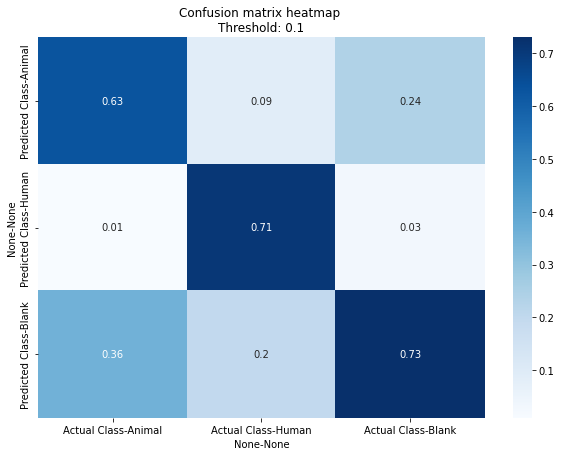

In [40]:
threshold=0.1
confusion_matrix = create_confusion_matrix(f"03_confusion-matrix-recall_{threshold}_independent-event.csv", normalization=True)
plt.figure(figsize = (10,7))
plt.title(
          'Confusion matrix heatmap \n' +
          f'Threshold: {threshold}'
          )
sn.heatmap(confusion_matrix, annot=True, cmap='Blues')
save_image_Google_drive(plt, root, image_folder, f"by independent event/03_confusion-matrix-heatmap_{threshold}.jpg")

File is saved to by independent event/03_confusion-matrix-heatmap_0.5.jpg in Google Drive at /content/drive/My Drive/FFI/MegaDetector Test/confusion-matrix/visualization/by independent event/03_confusion-matrix-heatmap_0.5.jpg


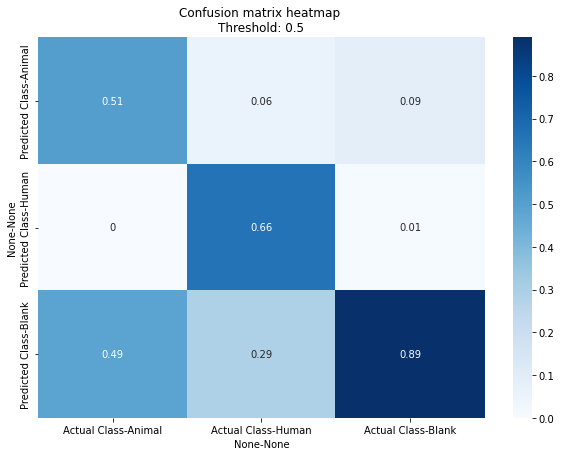

In [39]:
threshold=0.5
confusion_matrix = create_confusion_matrix(f"03_confusion-matrix-recall_{threshold}_independent-event.csv", normalization=True)
plt.figure(figsize = (10,7))
plt.title(
          'Confusion matrix heatmap \n' +
          f'Threshold: {threshold}'
          )
sn.heatmap(confusion_matrix, annot=True, cmap='Blues')
save_image_Google_drive(plt, root, image_folder, f"by independent event/03_confusion-matrix-heatmap_{threshold}.jpg")

File is saved to by independent event/03_confusion-matrix-heatmap_0.9.jpg in Google Drive at /content/drive/My Drive/FFI/MegaDetector Test/confusion-matrix/visualization/by independent event/03_confusion-matrix-heatmap_0.9.jpg


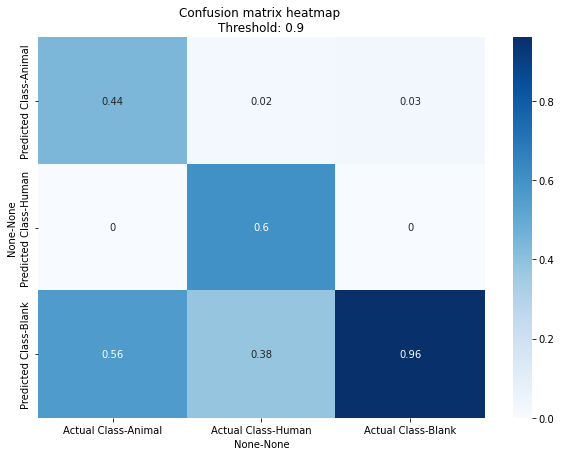

In [41]:
threshold=0.9
confusion_matrix = create_confusion_matrix(f"03_confusion-matrix-recall_{threshold}_independent-event.csv", normalization=True)
plt.figure(figsize = (10,7))
plt.title(
          'Confusion matrix heatmap \n' +
          f'Threshold: {threshold}'
          )
sn.heatmap(confusion_matrix, annot=True, cmap='Blues')
save_image_Google_drive(plt, root, image_folder, f"by independent event/03_confusion-matrix-heatmap_{threshold}.jpg")

In [99]:
# comparison table
comparison_table = pd.DataFrame(index=['Animal recall', 'Human recall', 'Reduction rate'])

for j in range(1, 10):
  i = j/10
  confusion_matrix_recall_i = create_confusion_matrix(f"03_confusion-matrix_{i}_independent-event.csv")
  confusion_matrix_recall_i = read_csv_Google_drive(root, contain_folder, f"03_confusion-matrix_{i}_independent-event.csv")
  confusion_matrix_recall_i.set_index('Unnamed: 0', inplace=True)
  confusion_matrix_recall_i = confusion_matrix_recall_i.T
  animal_column = confusion_matrix_recall_i['All'] - confusion_matrix_recall_i['Blank'] - confusion_matrix_recall_i['Human'] 
  animal_recall = round(animal_column['Animal'] / animal_column['Total'], 2)
  human_recall = round(confusion_matrix_recall_i.loc['Human', 'Human'] / confusion_matrix_recall_i.loc['Total', 'Human'], 2)
  reduction_rate = round(confusion_matrix_no_trigger.loc['Blank', 'All'] / confusion_matrix_no_trigger.loc['Total', 'All'], 2)
  comparison_table[f"{i}"] = [animal_recall, human_recall, reduction_rate]

save_csv_Google_drive(comparison_table, root, contain_folder, threshold_recall_matrix_file_name, index=True)

comparison_table

File is saved to 03_threshold-recall-reduction.csv in Google Drive at /content/drive/My Drive/FFI/MegaDetector Test/confusion-matrix/data cleaning/03_threshold-recall-reduction.csv


,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
Animal recall,0.63,0.58,0.55,0.53,0.51,0.50,0.48,0.46,0.44
Human recall,0.71,0.69,0.68,0.67,0.66,0.65,0.64,0.62,0.60
Reduction rate,0.63,0.70,0.73,0.76,0.78,0.79,0.81,0.83,0.85


In [34]:
# comparison table

comparison_table = pd.DataFrame(index=['Animal recall', 'Human recall', 'Reduction rate'])

range = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for i in range:
  confusion_matrix_no_trigger = read_confusion_matrix_Google_drive(root, contain_folder, f"03_confusion-matrix-recall_{i}_without-independent-event.csv")
  confusion_matrix_recall     = read_confusion_matrix_Google_drive(root, contain_folder, f"03_confusion-matrix-recall_{i}_independent-event.csv")
  
  animal_column  = confusion_matrix_recall['All'] - confusion_matrix_recall['Blank'] - confusion_matrix_recall['Human'] 
  animal_recall  = round(animal_column['Animal'] / animal_column['Total'], 2)
  human_recall   = round(confusion_matrix_recall.loc['Human', 'Human'] / confusion_matrix_recall.loc['Total', 'Human'], 2)
  reduction_rate = round(confusion_matrix_no_trigger.loc['Blank', 'All'] / confusion_matrix_no_trigger.loc['Total', 'All'], 2)
  comparison_table[f"{i}"] = [animal_recall, human_recall, reduction_rate]

save_csv_Google_drive(comparison_table, root, contain_folder, threshold_recall_matrix_file_name, index=True)

comparison_table

File is saved to 03_threshold-recall-reduction.csv in Google Drive at /content/drive/My Drive/FFI/MegaDetector Test/confusion-matrix/data cleaning/03_threshold-recall-reduction.csv


,0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
Animal recall,0.63,0.63,0.58,0.55,0.53,0.51,0.50,0.48,0.46,0.44
Human recall,0.71,0.71,0.69,0.68,0.67,0.66,0.65,0.64,0.62,0.60
Reduction rate,0.64,0.64,0.71,0.74,0.76,0.78,0.80,0.82,0.83,0.85


File is saved to by independent event/03_threshold-recall-reduction.jpg in Google Drive at /content/drive/My Drive/FFI/MegaDetector Test/confusion-matrix/visualization/by independent event/03_threshold-recall-reduction.jpg


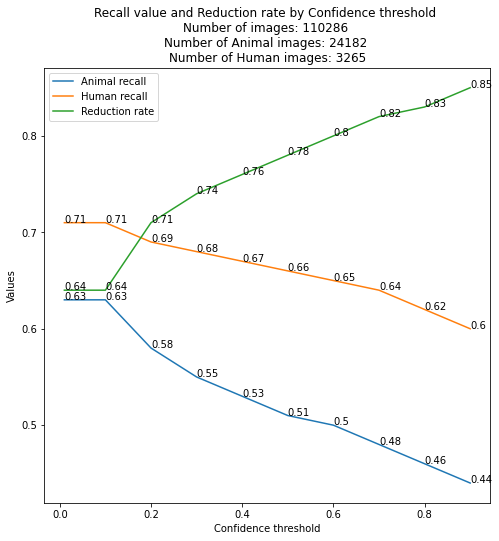

In [37]:
plt.figure(figsize=(8,8))
x = range

y = comparison_table.loc['Animal recall']
plt.plot(x, y, label='Animal recall')
for a,b in zip(x, y): 
    plt.text(a, b, str(b))

y = comparison_table.loc['Human recall']
plt.plot(x, y, label='Human recall')
for a,b in zip(x, y): 
    plt.text(a, b, str(b))

y = comparison_table.loc['Reduction rate']
plt.plot(x, y, label='Reduction rate')
for a,b in zip(x, y): 
    plt.text(a, b, str(b))

confusion_matrix_recall_10 = read_confusion_matrix_Google_drive(root, contain_folder, f"03_confusion-matrix-recall_0.1_without-independent-event.csv")

total_total = confusion_matrix_recall_10.loc['Total', 'All']
human_total = confusion_matrix_recall_10.loc['Total', 'Human']
blank_total = confusion_matrix_recall_10.loc['Total', 'Blank']
animal_total = total_total - human_total - blank_total


plt.xlabel('Confidence threshold')
plt.ylabel('Values')
plt.legend()
plt.title(
    'Recall value and Reduction rate by Confidence threshold \n' +
    f'Number of images: {round(total_total)} \n' +
    f'Number of Animal images: {round(animal_total)} \n' + 
    f'Number of Human images: {round(human_total)}'
    )

save_image_Google_drive(plt, root, image_folder, threshold_recall_plot_file_name)